# Convert the downloaded NRR precipitation geotiffs to a NetCDF dataset

This Notebook converts the downloaded Nationale Regenradar (NRR) geotiffs to a NetCDF dataset (Nelen & Schuurmans,2023). This dataset is then postprocessed. The variables are renamed, the data is resampled from per 5 minutes to per 1 hour, and the coordinates are interpolated to the coordinates of the Wflow_sbm Geul parameterset.

Nelen & Schuurmans. (2023). <I>Welcome to the Lizard documentation! -- Lizard 2022.02 documentation.</I> Retrieved from: https://docs.lizard.net/a_lizard.html

The code is shown for the calibration period, the validation period is commented. When you want to build the validation datset, uncomment these lines and comment the lines of the calibration period.

## Import the required packages

In [1]:
import os
import pandas as pd
import xarray as xr
import rioxarray
import numpy as np

## Define the folder with the downloaded tif files

Define the folder where the downloaded geotiff files are located. Choose between the calibration or validation period.

In [2]:
# Calibration
folder = r"C:\Users\924259\Documents\NRR_output_calibration"
# Validation
#folder = r"C:\Users\924259\Documents\NRR_output_validation"

## Define all geotiffs

In [3]:
def get_timestamps(folder):
    '''
    Returns the timestamps and files of the geotiffs in the given folder
    Input: Folder where the downloaded geotiffs are located
    Output: Timestamps and files of the downloaded geotiffs
    '''
    
    timestamps = []
    files = []
    
    for r, d, f in os.walk(folder):

        for file in f:

            if file.endswith('.tif'):

                datestring = file[4:-5].replace('-','').replace('_','')
                timestamps.append(pd.to_datetime(datestring))
                files.append(os.path.join(r, file))

    return xr.Variable('time', timestamps), files

## Get the time and file arrays

Run the formula get_timestamps() for the defined folder and get the timestamps and files of the downloaded geotiffs

In [4]:
time, files = get_timestamps(folder)

## Open and combine the geotiffs

All the downloaded geotiffs are opened and combined to one dataset with the function xr.concat(), with the timestamps as index

In [5]:
da = xr.concat([rioxarray.open_rasterio(f) for f in files], dim=time)

KeyboardInterrupt: 

## Save the combined geotiffs as NetCDF

Save the NetCDF file with the combined geotiffs. Choose between the calibration and validation period. Be consistent!

In [ ]:
# Calibration
da.to_netcdf(r"C:\Users\924259\Documents\NRR_output_calibration\NRR_data_calibration.nc")

# Validation
#da.to_netcdf(r"C:\Users\924259\Documents\NRR_output_validation\NRR_data_validation.nc")

## Open the saved NetCDF

Open the saved NetCDF of the previous step. Choose between the calibration and validation period. Be consistent!

In [17]:
# Calibration
ds = xr.open_dataset(r"C:\Users\924259\Documents\NRR_output_calibration\NRR_data_calibration.nc")

# Validation
#ds = xr.open_dataset(r"C:\Users\924259\Documents\NRR_output_validation\NRR_data_validation.nc")

## Rename the variable name and assign unit

The variable name is renamed to a more useful name, 'precipitation'. Also, an unit is added.

In [18]:
ds = ds.rename_vars({'__xarray_dataarray_variable__':'precipitation'})
ds.precipitation.attrs['unit'] = 'mm'

In [19]:
ds

<xarray.Dataset>
Dimensions:        (band: 1, x: 32, y: 37, time: 184033)
Coordinates:
  * band           (band) int32 1
  * x              (x) float64 5.705 5.719 5.734 5.748 ... 6.12 6.134 6.148
  * y              (y) float64 50.95 50.94 50.93 50.92 ... 50.64 50.63 50.62
  * time           (time) datetime64[ns] 2020-07-01 ... 2022-04-01
Data variables:
    spatial_ref    int32 ...
    precipitation  (time, band, y, x) float32 ...

## Data check

Check the dataset for the correct area and units

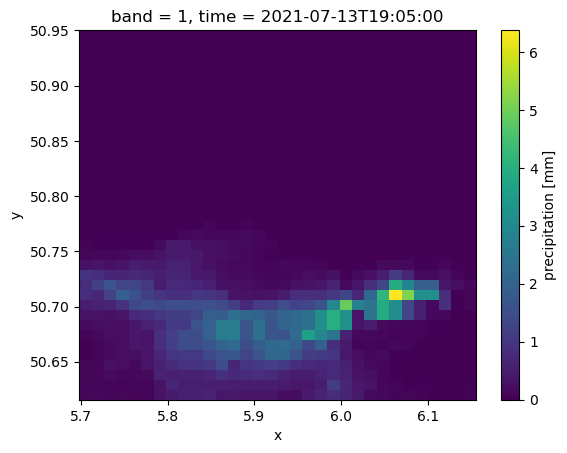

In [20]:
ds.precipitation.isel(time=108805).plot()

## Resample from mm/5min to mm/h

Hourly data is needed, so the data is resampled from per 5 minutes to per 1 hour. This is done by summing the precipitation values per hour, as the data is provided in mm/5min

In [21]:
ds_resample = ds.resample(time='1H').sum()

In [22]:
ds_resample

<xarray.Dataset>
Dimensions:        (band: 1, x: 32, y: 37, time: 15337)
Coordinates:
  * band           (band) int32 1
  * x              (x) float64 5.705 5.719 5.734 5.748 ... 6.12 6.134 6.148
  * y              (y) float64 50.95 50.94 50.93 50.92 ... 50.64 50.63 50.62
  * time           (time) datetime64[ns] 2020-07-01 ... 2022-04-01
Data variables:
    spatial_ref    (time) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    precipitation  (time, band, y, x) float32 2.26 2.4 2.52 2.46 ... 0.0 0.0 0.0

## Save dataset

The original dataset, before the coordinates are interpolated, is downloaded and is used for precipitation data analysis. Choose between the calibration and validation dataset. Be consistent!

In [1]:
# Calibration
ds_resample.to_netcdf(r"C:\Users\924259\Documents\NRR_output_calibration\NRR_data_calibration_org.nc")

# Validation
#ds_resample.to_netcdf(r"C:\Users\924259\Documents\NRR_output_validation\NRR_data_validation_org.nc")

NameError: name 'ds_resample' is not defined

## Interpolate to wflow_sbm model coordinates

The coordinates of the dataset do not match the wflow_sbm Geul model coordinates and this result in a not running model. So, the coordinates are interpolated to the coordinates of the model.

In [23]:
new_latitudes = np.array([50.9175,50.909167,50.900833,50.8925,50.884167,50.875833,50.8675,50.859167,50.850833,50.8425,
                          50.834167,50.825833,50.8175,50.809167,50.800833,50.7925,50.784167,50.775833,50.7675,50.759167,
                          50.750833,50.7425,50.734167,50.725833,50.7175,50.709167,50.700833,50.6925,50.684167,50.675833,
                          50.6675,50.659167,50.650833])
new_longitudes = np.array([5.718333,5.726667,5.735,5.743333,5.751667,5.76,5.768333,5.776667,5.785,5.793333,5.801667,5.81,
                           5.818333,5.826667,5.835,5.843333,5.851667,5.86,5.868333,5.876667,5.885,5.893333,5.901667,5.91,
                           5.918333,5.926667,5.935,5.943333,5.951667,5.96,5.968333,5.976667,5.985,5.993333,6.001667,6.01,
                           6.018333,6.026667,6.035,6.043333,6.051667,6.06,6.068333,6.076667,6.085,6.093333,6.101667,6.11,
                           6.118333,6.126667])
ds_resampled = ds_resample.interp(y=new_latitudes, x=new_longitudes)

In [24]:
ds_resampled

<xarray.Dataset>
Dimensions:        (band: 1, time: 15337, y: 33, x: 50)
Coordinates:
  * band           (band) int32 1
  * time           (time) datetime64[ns] 2020-07-01 ... 2022-04-01
  * y              (y) float64 50.92 50.91 50.9 50.89 ... 50.67 50.66 50.65
  * x              (x) float64 5.718 5.727 5.735 5.743 ... 6.11 6.118 6.127
Data variables:
    spatial_ref    (time) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    precipitation  (time, band, y, x) float64 2.942 2.882 2.812 ... 0.0 0.0 0.0

## Check new coordinates 

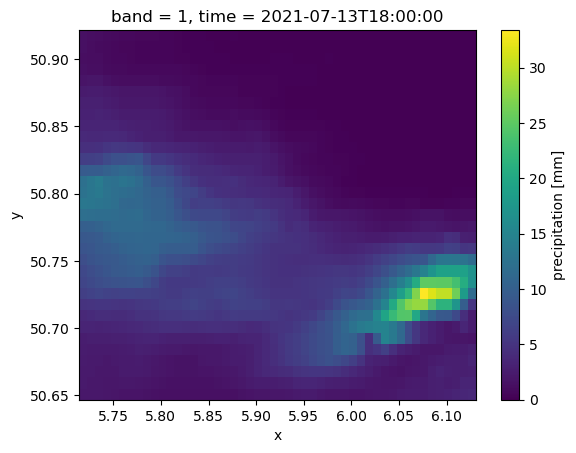

In [25]:
ds_resampled.precipitation.isel(time=9066).plot()

## Save the resampled dataset

Save the final version of the NRR dataset. Choose between the calibration and validation period. Be consistent!

In [26]:
# Calibration
ds_resampled.to_netcdf(r"C:\Users\924259\Documents\NRR_output_calibration\NRR_data_calibration_adjusted.nc")

# Validation
#ds_resampled.to_netcdf(r"C:\Users\924259\Documents\NRR_output_validation\NRR_data_validation_adjusted.nc")